### Note:
This code for the fine-tuning process of XLNet for sentiment analysis is based on the following example, published on Medium: <br>
- link to article: https://medium.com/swlh/using-xlnet-for-sentiment-classification-cfa948e65e85 <br>
- author: Shanay Ghag <br>
- published at: Jun 16, 2020 <br>
- link to GitHub: https://github.com/shanayghag/Sentiment-classification-using-XLNet

In [1]:
from datasets import load_dataset_builder, load_dataset
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import re

import sentencepiece
from collections import defaultdict

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler, Dataset, DataLoader
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# set up connection to drive: 
#from google.colab import drive
#drive.mount('/content/drive')

# define device: 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def prepare_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text) # remove @user 
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text) # remove links
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text) # remove smileys
    text = re.sub('#', '', text) # remove hash sign
    text = re.sub('\t', ' ',  text) # remove tab
    text = re.sub(r" +", ' ', text) # remove multiple whitespaces
    return text

# 1. Prepare Sentiment Dataset for Fine-Tuning

In [4]:
# load dataset from hugging face hub: sentiment140
sentiment_data = load_dataset('sentiment140')

Generating train split:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/498 [00:00<?, ? examples/s]

Dataset sentiment140 downloaded and prepared to /root/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
sentiment_data_train = load_dataset('sentiment140', split='train')
sentiment_data_test = load_dataset('sentiment140', split='test')

In [6]:
text = sentiment_data_train['text']
sentiment = sentiment_data_train['sentiment']
df_sentiment = pd.DataFrame({'text': text, 'sentiment': sentiment})

# plot length of each tweet in order to define max_length
# define tokenizer:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

token_lens = []

for txt in df_sentiment['text']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

sns_plot = sns.distplot(token_lens)
plt.xlim([0, 400]);
plt.xlabel('Token count')

fig = sns_plot.get_figure()
fig.savefig('token_length_sentiment.png');

In [7]:
# Create Multiple Subsets: Two options possible: Either always resample or create subsets that don't overlap
# Created non-overlapping subsets
df_sentiment = shuffle(df_sentiment) # 0 = negative; 2 = neutral; 4 = positive
dataset_lst = []
for i in range(10):
    dataset_lst.append(df_sentiment[i*24000:(i+1)*24000]) #test only

In [8]:
def dataset_preprocessing(df_sent):
    df_sent['text'] = df_sent['text'].apply(prepare_text)
    df_sent.loc[(df_sent.sentiment == 4),'sentiment']=1 # change label: 0: negative; 1: positive
    
    # sns_plot = sns.countplot(x=df_sent.sentiment) # to see class distribution
    print(f'negative tweets: {len(df_sent[df_sent["sentiment"] == 0])}')
    print(f'positive tweets: {len(df_sent[df_sent["sentiment"] == 1])}')
    '''
    fig = sns_plot.get_figure()
    fig.savefig('class_dist_sentiment.png');
    '''
    return df_sent

# 2. Load XLNet, Prepare Inputs and Define Hyperparameter

In [9]:
# custom dataset class
class SentimentDataset(Dataset):
    
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
    
        encoding = self.tokenizer.encode_plus(review,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              truncation=True,
                                              return_token_type_ids=False,
                                              pad_to_max_length=False,
                                              return_attention_mask=True,
                                              return_tensors='pt',)
        
        input_ids = pad_sequences(encoding['input_ids'], 
                                  maxlen=MAX_LEN, 
                                  dtype=torch.Tensor ,
                                  truncating="post",
                                  padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], 
                                       maxlen=MAX_LEN, 
                                       dtype=torch.Tensor ,
                                       truncating="post",
                                       padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       
        
        return {'review_text': review,
                'input_ids': input_ids,
                'attention_mask': attention_mask.flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [10]:
# define custom dataloader:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SentimentDataset(reviews=df.text.to_numpy(),
                          targets=df.sentiment.to_numpy(),
                          tokenizer=tokenizer,
                          max_len=max_len)
    
    return DataLoader(ds,
                    batch_size=batch_size,
                    num_workers=2)                    

In [11]:
# define training step function:
from sklearn import metrics

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples, progress_bar):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].reshape(8,400).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]
        
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        counter = counter + 1
    
    return acc / counter, np.mean(losses)

In [12]:
# define evaluation function:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(8,400).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]
            
            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)
            
            acc += accuracy
            losses.append(loss.item())
            counter += 1
        
    return acc / counter, np.mean(losses)

In [13]:
# define function to get prediction of data
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(8,400).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids,
                      token_type_ids=None,
                      attention_mask=attention_mask,#
                      labels=targets)
            
            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)
            probs = F.softmax(outputs[1], dim=1)
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return review_texts, predictions, prediction_probs, real_values

In [14]:
# read model saved in previous step:
# when connected to GPU:
#model.load_state_dict(torch.load('xlnet_model_sentiment.bin'))

# when not connected to GPU (hence no cuda):
#model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/models/xlnet_model_sentiment.bin', map_location=torch.device('cpu')))

In [15]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix/ confusion_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')
    plt.savefig('confusion_sentiment');


In [16]:
from transformers import XLNetForSequenceClassification
import copy

xlnet_model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

negative tweets: 12019
positive tweets: 11981


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration 0 Epoch 1/2
Train loss 0.5151850004071991 Train accuracy 0.7595833333333334
Val loss 0.417397802323103 Val accuracy 0.8186666666666667

Iteration 0 Epoch 2/2
Train loss 0.3729870688126733 Train accuracy 0.8623333333333333
Val loss 0.5394266193788498 Val accuracy 0.8293333333333334



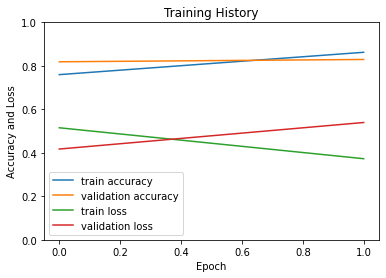

Test Accuracy : 0.8261666666666667
Test Loss : 0.5374327713946502
              precision    recall  f1-score   support

    negative       0.82      0.84      0.83      2986
    positive       0.84      0.81      0.82      3014

    accuracy                           0.83      6000
   macro avg       0.83      0.83      0.83      6000
weighted avg       0.83      0.83      0.83      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


negative tweets: 12025
positive tweets: 11975


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration 1 Epoch 1/2
Train loss 0.5536328802357118 Train accuracy 0.7163333333333334
Val loss 0.4314819043179353 Val accuracy 0.8128333333333333

Iteration 1 Epoch 2/2
Train loss 0.3871171425717572 Train accuracy 0.8540833333333333
Val loss 0.5500740377586335 Val accuracy 0.8198333333333333



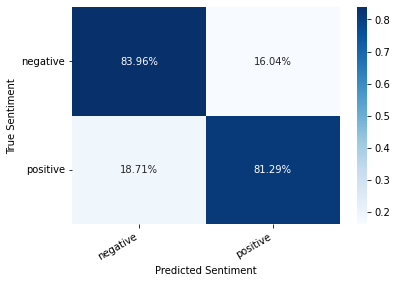

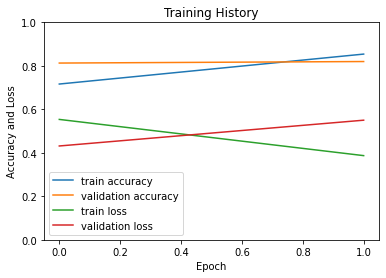

Test Accuracy : 0.82
Test Loss : 0.5486615842444201
              precision    recall  f1-score   support

    negative       0.81      0.83      0.82      2986
    positive       0.83      0.81      0.82      3014

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


negative tweets: 12009
positive tweets: 11991


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration 2 Epoch 1/2
Train loss 0.5346688550561667 Train accuracy 0.7416666666666667
Val loss 0.4480200848281384 Val accuracy 0.8028333333333333

Iteration 2 Epoch 2/2
Train loss 0.37913922453392296 Train accuracy 0.86075
Val loss 0.6167136183641851 Val accuracy 0.8251666666666667



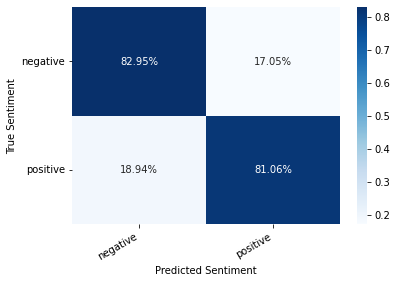

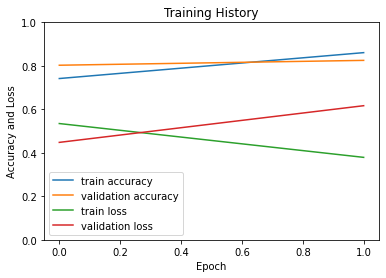

Test Accuracy : 0.8308333333333333
Test Loss : 0.5982322957739235
              precision    recall  f1-score   support

    negative       0.82      0.85      0.83      2996
    positive       0.84      0.82      0.83      3004

    accuracy                           0.83      6000
   macro avg       0.83      0.83      0.83      6000
weighted avg       0.83      0.83      0.83      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


negative tweets: 12005
positive tweets: 11995


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration 3 Epoch 1/2
Train loss 0.5528913668592771 Train accuracy 0.7185
Val loss 0.46427065977454185 Val accuracy 0.794

Iteration 3 Epoch 2/2
Train loss 0.3879842935049285 Train accuracy 0.8460833333333333
Val loss 0.5961996165104211 Val accuracy 0.8065



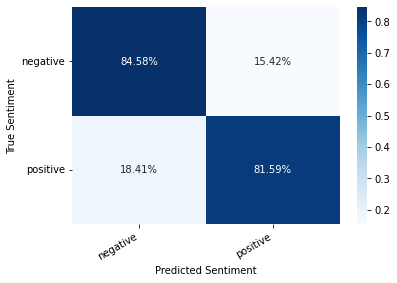

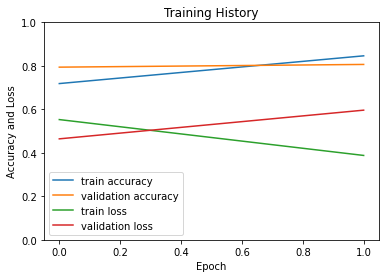

Test Accuracy : 0.8153333333333334
Test Loss : 0.5755644825498263
              precision    recall  f1-score   support

    negative       0.81      0.82      0.82      3003
    positive       0.82      0.81      0.81      2997

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


negative tweets: 12049
positive tweets: 11951


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration 4 Epoch 1/2
Train loss 0.5121595265020927 Train accuracy 0.76725
Val loss 0.4284312709967295 Val accuracy 0.8078333333333333

Iteration 4 Epoch 2/2
Train loss 0.3689634322480609 Train accuracy 0.8691666666666666
Val loss 0.5854484712593258 Val accuracy 0.8233333333333334



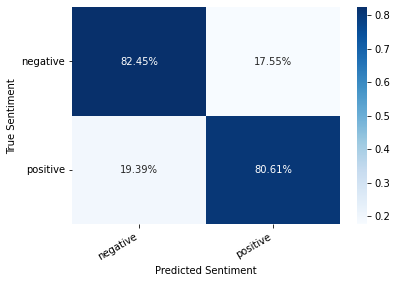

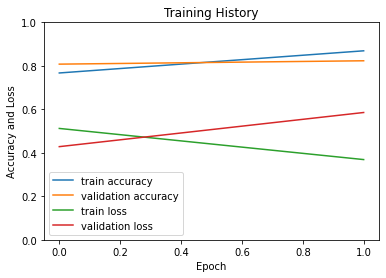

Test Accuracy : 0.8238333333333333
Test Loss : 0.5945380238754054
              precision    recall  f1-score   support

    negative       0.83      0.83      0.83      3058
    positive       0.82      0.82      0.82      2942

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


negative tweets: 12016
positive tweets: 11984


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration 5 Epoch 1/2
Train loss 0.7042378326455752 Train accuracy 0.51
Val loss 0.6483582249482472 Val accuracy 0.6326666666666667

Iteration 5 Epoch 2/2
Train loss 0.5188125046044588 Train accuracy 0.7579166666666667
Val loss 0.4612222733944654 Val accuracy 0.8023333333333333



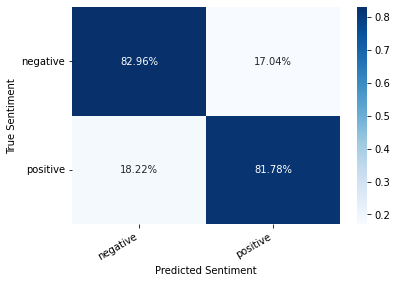

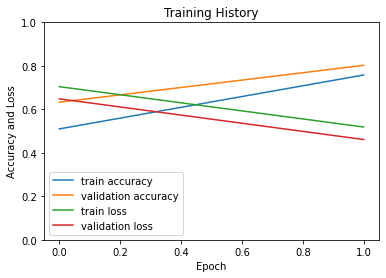

Test Accuracy : 0.8003333333333333
Test Loss : 0.45233532206217447
              precision    recall  f1-score   support

    negative       0.78      0.82      0.80      2932
    positive       0.82      0.78      0.80      3068

    accuracy                           0.80      6000
   macro avg       0.80      0.80      0.80      6000
weighted avg       0.80      0.80      0.80      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


negative tweets: 11910
positive tweets: 12090


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration 6 Epoch 1/2
Train loss 0.5135628078033527 Train accuracy 0.7638333333333334
Val loss 0.45693356546759606 Val accuracy 0.7981666666666667

Iteration 6 Epoch 2/2
Train loss 0.3843328229694938 Train accuracy 0.8663333333333333
Val loss 0.6366037101726979 Val accuracy 0.8135



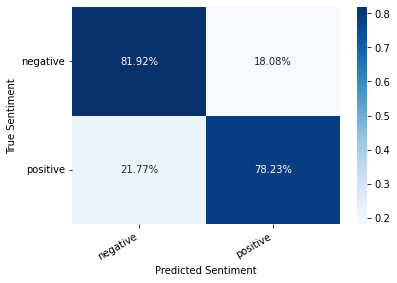

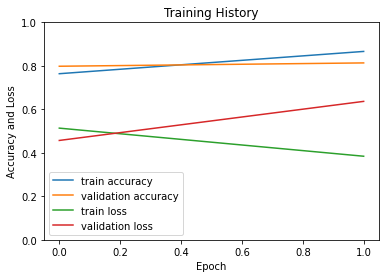

Test Accuracy : 0.8285
Test Loss : 0.577487745616585
              precision    recall  f1-score   support

    negative       0.81      0.87      0.84      3059
    positive       0.85      0.78      0.82      2941

    accuracy                           0.83      6000
   macro avg       0.83      0.83      0.83      6000
weighted avg       0.83      0.83      0.83      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


negative tweets: 12022
positive tweets: 11978


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration 7 Epoch 1/2
Train loss 0.5223552025953928 Train accuracy 0.7554166666666666
Val loss 0.48174775955826044 Val accuracy 0.804

Iteration 7 Epoch 2/2
Train loss 0.38795262411236764 Train accuracy 0.8640833333333333
Val loss 0.5990462916549295 Val accuracy 0.8233333333333334



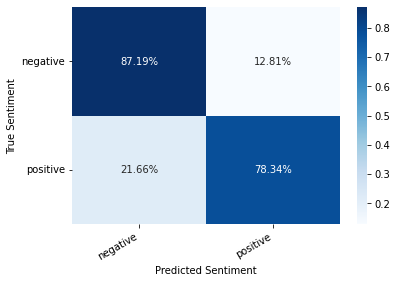

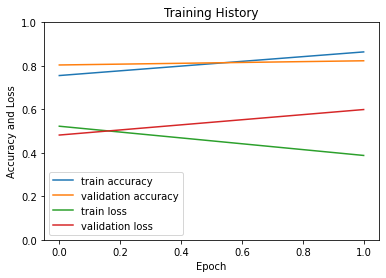

Test Accuracy : 0.8196666666666667
Test Loss : 0.6246358536717792
              precision    recall  f1-score   support

    negative       0.83      0.82      0.83      3122
    positive       0.81      0.82      0.81      2878

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


negative tweets: 11900
positive tweets: 12100


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration 8 Epoch 1/2
Train loss 0.5994525288591782 Train accuracy 0.6589166666666667
Val loss 0.44829595932364463 Val accuracy 0.7978333333333333

Iteration 8 Epoch 2/2
Train loss 0.4129373233020306 Train accuracy 0.83525
Val loss 0.5041470780670643 Val accuracy 0.8215



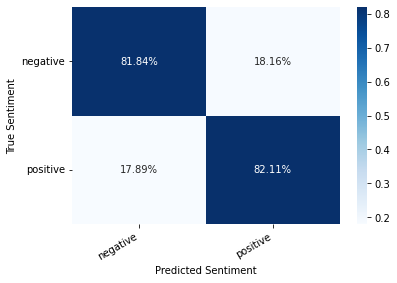

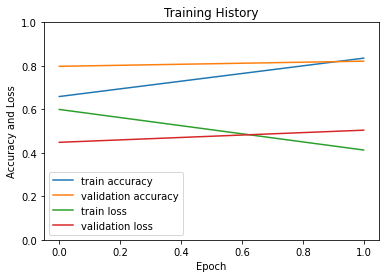

Test Accuracy : 0.822
Test Loss : 0.5083541648735602
              precision    recall  f1-score   support

    negative       0.83      0.81      0.82      3012
    positive       0.82      0.83      0.82      2988

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


negative tweets: 11982
positive tweets: 12018


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration 9 Epoch 1/2
Train loss 0.53769221124053 Train accuracy 0.74225
Val loss 0.4770416808674733 Val accuracy 0.7951666666666667

Iteration 9 Epoch 2/2
Train loss 0.3821518471216162 Train accuracy 0.85575
Val loss 0.5507490573711693 Val accuracy 0.8128333333333333



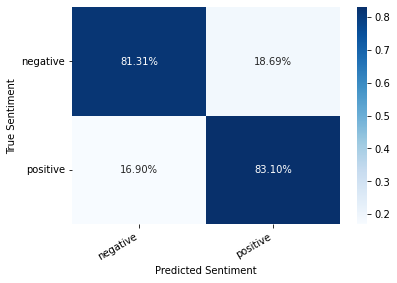

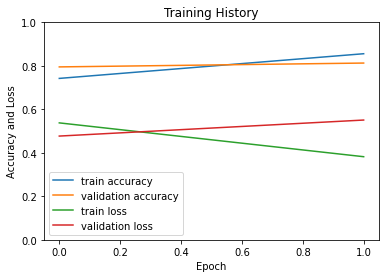

Test Accuracy : 0.8191666666666667
Test Loss : 0.531291053035607
              precision    recall  f1-score   support

    negative       0.81      0.84      0.82      3009
    positive       0.83      0.80      0.82      2991

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


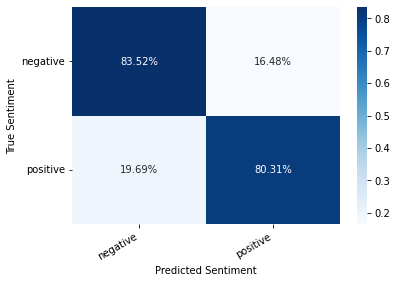

In [17]:
report_lst = []
for i in range(len(dataset_lst)):
    df_sent = dataset_lst[i].copy()
    df_sent = dataset_preprocessing(df_sent)
    
    # create training, validation and test set: 
    MAX_LEN = 400
    df_train, df_test = train_test_split(df_sent, test_size=0.5, random_state=101)
    df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)

    # define batch size: 
    BATCH_SIZE = 8

    # create data loader for training, validation and test set: 
    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

    # load pre-trained XLNet model
    model = copy.deepcopy(xlnet_model)

    model = model.to(device)

    # defining hyperparameters:
    EPOCHS = 2

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}]

    optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
    total_steps = len(train_data_loader) * EPOCHS

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    # sanity check: 
    '''
    data = next(iter(val_data_loader))
    data.keys()
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    targets = data['targets'].to(device)

    print(input_ids.reshape(8,400).shape) # batch size x seq length
    print(attention_mask.shape) # batch size x seq length

    outputs = model(input_ids.reshape(8,400), 
                    token_type_ids=None, 
                    attention_mask=attention_mask, 
                    labels=targets) '''

    history = defaultdict(list)
    best_accuracy = 0
    num_training_steps = EPOCHS * len(train_data_loader)
    progress_bar = tqdm(range(num_training_steps))

    for epoch in range(EPOCHS):
        print(f'Iteration {i} Epoch {epoch + 1}/{EPOCHS}')
        # print('-' * 10)

        # call train function
        train_acc, train_loss = train_epoch(model,
                                          train_data_loader,
                                          optimizer,
                                          device, 
                                          scheduler, 
                                          len(df_train),
                                           progress_bar)

        print(f'Train loss {train_loss} Train accuracy {train_acc}')

        # call evaluation function
        val_acc, val_loss = eval_model(model,
                                     val_data_loader, 
                                     device, 
                                     len(df_val))

        print(f'Val loss {val_loss} Val accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
         #   torch.save(model.state_dict(), 'xlnet_model_sentiment.bin') # note: this scrip was implemented using Kaggle's GPU. The model was saved into the Kaggle repo and downloaded manually
            best_accuracy = val_acc
    fig = plt.figure()
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')
    plt.title('Training History')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1])
    #fig.savefig('training_sentiment.png');
    plt.show()
    
    # EVALUATION
    # call evaluation function and apply to test set
    test_acc, test_loss = eval_model(model,
                                     test_data_loader,
                                     device,
                                     len(df_test))

    print('Test Accuracy :', test_acc)
    print('Test Loss :', test_loss)
    class_names = ['negative', 'positive']
    y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
    print(classification_report(y_test, y_pred, target_names=class_names))
    report = classification_report(y_test, y_pred, target_names=class_names,output_dict=True)
    report['accuracy'] = {'precision': None,
        'recall': None,
        'f1-score': report['accuracy'],
        'support': None}
    report = pd.DataFrame(report).transpose()
    #print(report)
    report_lst.append(report)
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    #df_cm.to_csv('cm_sentiment.csv')
    show_confusion_matrix(df_cm)

In [18]:
print(report_lst)

[              precision    recall  f1-score  support
negative       0.816346  0.839585  0.827803   2986.0
positive       0.836463  0.812873  0.824499   3014.0
accuracy            NaN       NaN  0.826167      NaN
macro avg      0.826405  0.826229  0.826151   6000.0
weighted avg   0.826452  0.826167  0.826143   6000.0,               precision    recall  f1-score  support
negative       0.812664  0.829538  0.821014   2986.0
positive       0.827575  0.810551  0.818974   3014.0
accuracy            NaN       NaN  0.820000      NaN
macro avg      0.820119  0.820044  0.819994   6000.0
weighted avg   0.820154  0.820000  0.819989   6000.0,               precision    recall  f1-score  support
negative       0.820862  0.845794  0.833142   2996.0
positive       0.841401  0.815912  0.828460   3004.0
accuracy            NaN       NaN  0.830833      NaN
macro avg      0.831131  0.830853  0.830801   6000.0
weighted avg   0.831145  0.830833  0.830798   6000.0,               precision    recall  f1-scor

In [19]:
# Average Results of all trained models
averages = pd.concat([ele for ele in report_lst]).groupby(level=0).mean()
print(averages)

              precision    recall  f1-score  support
accuracy            NaN       NaN  0.820583      NaN
macro avg      0.820950  0.820543  0.820479   6000.0
negative       0.814642  0.832677  0.823410   3016.3
positive       0.827258  0.808409  0.817549   2983.7
weighted avg   0.821010  0.820583  0.820530   6000.0


In [20]:
# 90% Confidence intervals
import math

confidence_table = pd.concat([ele for ele in report_lst]).groupby(level=0).agg(['mean', 'count', 'std'])

columns = []
for i, j in confidence_table:
    columns.append(i)
columns = list(set(columns))

for k in columns:
    confidence_low = []
    confidence_high = []
    for i in confidence_table.index:
        m, c, s = confidence_table.loc[i, k]
        try:
            confidence_high.append(m + 1.645*s/math.sqrt(c))
            confidence_low.append(m - 1.645*s/math.sqrt(c))
        except ZeroDivisionError:
            confidence_high.append(None)
            confidence_low.append(None)
        
    confidence_table[k, 'ci_lo'] = confidence_low
    confidence_table[k, 'ci_high']= confidence_high
print(confidence_table)

             precision                    recall                  f1-score  \
                  mean count       std      mean count       std      mean   
accuracy           NaN     0       NaN       NaN     0       NaN  0.820583   
macro avg     0.820950    10  0.008725  0.820543    10  0.008320  0.820479   
negative      0.814642    10  0.014217  0.832677    10  0.017047  0.823410   
positive      0.827258    10  0.013931  0.808409    10  0.015567  0.817549   
weighted avg  0.821010    10  0.008558  0.820583    10  0.008513  0.820530   

                             support                  precision            \
             count       std    mean count        std     ci_lo   ci_high   
accuracy        10  0.008513     NaN     0        NaN       NaN       NaN   
macro avg       10  0.008446  6000.0    10   0.000000  0.816412  0.825489   
negative        10  0.010205  3016.3    10  52.002244  0.807247  0.822038   
positive        10  0.007732  2983.7    10  52.002244  0.820011  0.8

In [21]:
confidence_table.to_csv('confidence_table.csv')
averages.to_csv('averages-csv')
results = pd.concat([ele for ele in report_lst])
results.to_csv('results.csv')